# Determining $\Sigma_{10}$ & $R_{10}$ for DESIJ1537+1443

Author(s): Md. Mehedi Hasan, Sulyman Hossain, Anowar Shajib\
Acknowledgement(s): Rafee Adnan, Ahmad Al - Imtiaz, Mamunur Rashid

## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.cosmology import FlatLambdaCDM
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [2]:
data, header = fits.getdata("DESIJ1537+1443_F140W_drz_sci.fits", header=True)

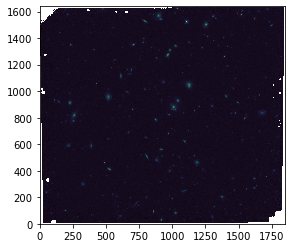

In [3]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/tmp/ipykernel_36593/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


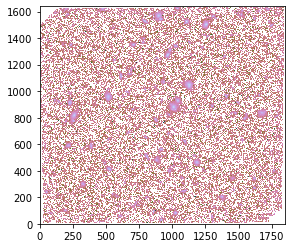

In [5]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [6]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.2555125818160815, 0.012066941302009332)

In [7]:
bkg_subtracted_data = data - bkg.background

In [8]:
threshold = 5 * bkg.background_rms

In [9]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [10]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [11]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (1640, 1849)
nlabels: 524
labels: [  1   2   3   4   5 ... 520 521 522 523 524]


In [12]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 524
labels: [  1   2   3   4   5 ... 520 521 522 523 524]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [13]:
set_x_lim1, set_x_lim2 = 500, 1500
set_y_lim1, set_y_lim2 = 600, 1350

/tmp/ipykernel_36593/2085321793.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


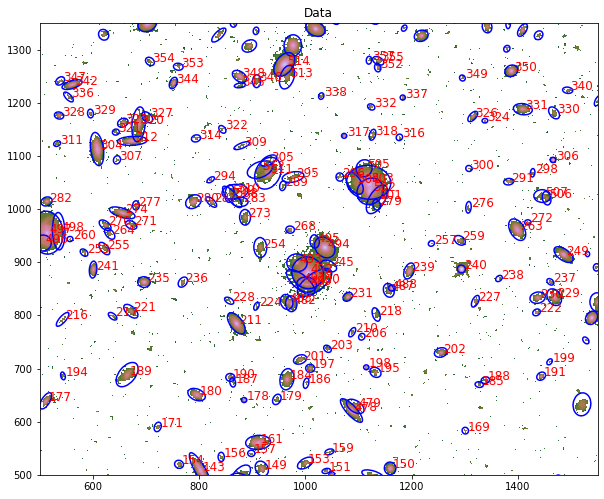

In [14]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)


for i in range(len(cat)):
    # cat.xcentroid[492]
    # cat.ycentroid[492]
    if np.abs(cat.xcentroid[i] - 1000) < 500 and np.abs(cat.ycentroid[i] - 900) < 400:
        ax1.text(
            cat.xcentroid[i] + 5,
            cat.ycentroid[i],
            f"{i}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2 + 50)
ax1.set_ylim(set_y_lim1 - 100, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/tmp/ipykernel_36593/125166765.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


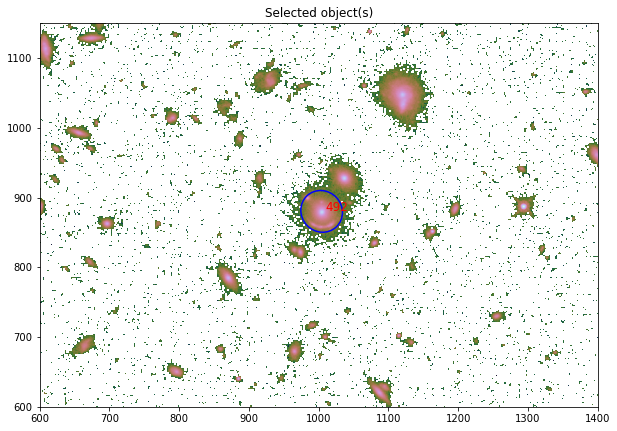

In [15]:
# object id of your central deflector/lens
id_central = 492


def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1 + 100, set_x_lim2 - 100)
    ax1.set_ylim(set_y_lim1, set_y_lim2 - 200)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


label_selected_objects([id_central])

In [16]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [17]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 20 arcsecond radius: 52


In [18]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 20 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 20 arcsecond radius: 42


In [19]:
def distance_parsec(pixel_distance):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180
    
    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian
    
    # Define cosmological parameters
    H0 = 70   # Hubble constant in km/s/Mpc
    Om0 = 0.3 # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Define the redshifts at which you want to compute the angular diameter distance
    z = 0.653
    
    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)
    
    # Calculate the physical distance
    physical_distances_parsecs = angular_diameter_distance * angles_radian

    return physical_distances_parsecs

## Unwanted Objects

/tmp/ipykernel_36593/125166765.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


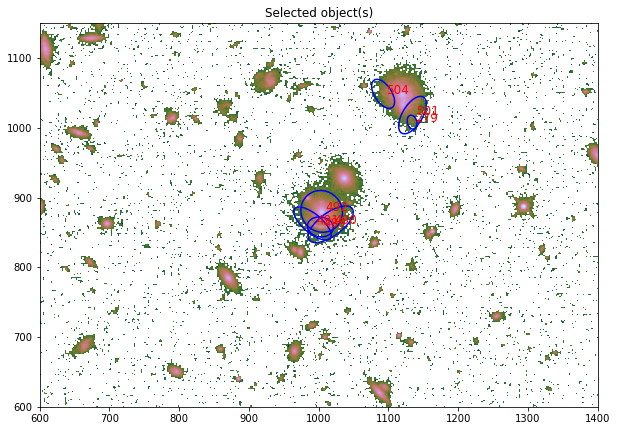

In [20]:
"""
Object with index 492 corresponds to our lens system, and
indices 489, 490, and 491 represent lensed arcs. On the other hand,
objects at indices 279, 501, and 504 are artefacts and
we intend to eliminate all of them from analysis.
"""

remove_list = [492, 490, 489, 279, 501, 504, 491]
label_selected_objects(remove_list)

## Removing the unwanted objects from the neighboring galaxy list

In [21]:
remove_list = [492, 490, 489, 279, 501, 504, 491]
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratio
493         27.450955              0.015247   59.500325    0.879821
245         41.464015              0.023031   15.825889    0.612749
494         57.385546              0.031874  367.563085    0.795376
495         60.363967              0.033528   11.698629    0.698588
482         65.963820              0.036639   51.045223    0.724551
483         67.642369              0.037571   28.428837    0.797171
268         87.609068              0.048661    6.883718    0.827438
231         87.890412              0.048818   31.715110    0.763029
254        100.986375              0.056092   22.250601    0.640861
224        115.087705              0.063924    2.675216    0.529625
210        139.788114              0.077644    3.237038    0.496466
203        147.891034              0.082144    3.116745    0.736578
218        150.958117              0.083848    6.830180    0.521050
487        156.250228              0.086787   16

In [22]:
# Excluding galaxies lower than 1% of the central deflector
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratioe"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratioe
493         27.450955              0.015247   59.500325     0.879821
245         41.464015              0.023031   15.825889     0.612749
494         57.385546              0.031874  367.563085     0.795376
495         60.363967              0.033528   11.698629     0.698588
482         65.963820              0.036639   51.045223     0.724551
483         67.642369              0.037571   28.428837     0.797171
268         87.609068              0.048661    6.883718     0.827438
231         87.890412              0.048818   31.715110     0.763029
254        100.986375              0.056092   22.250601     0.640861
218        150.958117              0.083848    6.830180     0.521050
487        156.250228              0.086787   16.430336     0.754941
273        157.380579              0.087415   17.924905     0.693093
488        160.955559              0.089401   48.383256     0.909308
201        163.790465             

## Determining Sigma 10, 20 and R 10, 20

/tmp/ipykernel_36593/1729084927.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_36593/1729084927.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_36593/1729084927.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_36593/1729084927.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


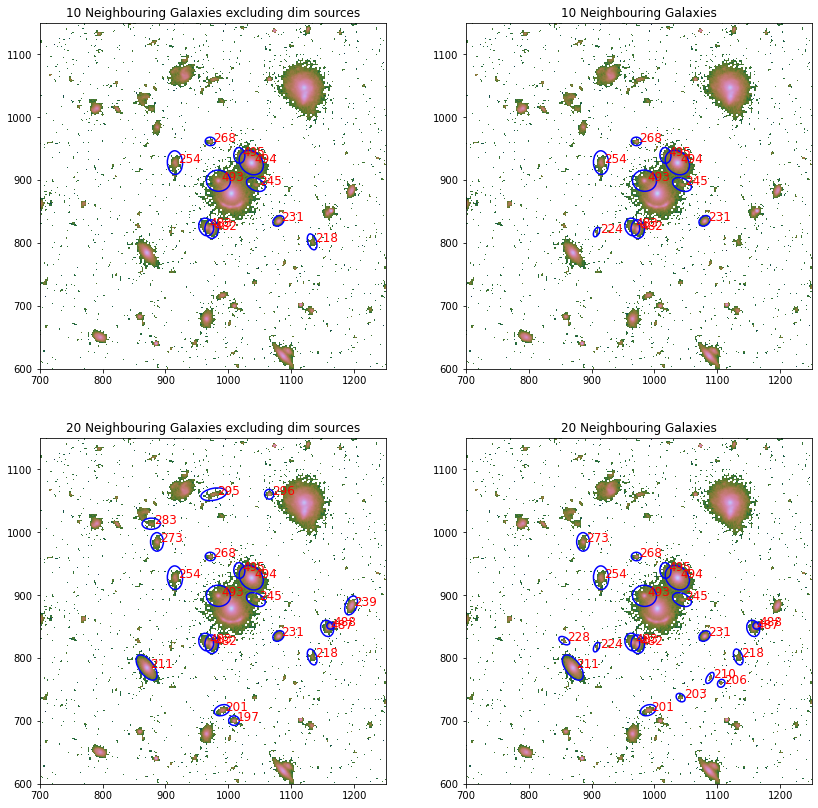

In [23]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1 + 200, set_x_lim2 - 250)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2 - 200)

axs[0, 1].set_xlim(set_x_lim1 + 200, set_x_lim2 - 250)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2 - 200)

axs[1, 0].set_xlim(set_x_lim1 + 200, set_x_lim2 - 250)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2 - 200)

axs[1, 1].set_xlim(set_x_lim1 + 200, set_x_lim2 - 250)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2 - 200)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Calculating $\Sigma_{10}$, $\Sigma_{10,\text{flux selected}}$ , $\Sigma_{20}$, $\Sigma_{20,\text{flux selected}}$ and the corresponding radii

## Method A

In [24]:
# For all sources
R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# Excluding dim sources
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.06392409791855758
R 20: 0.09142966101883529
Sigma 10: 778.9703208226316
Sigma 20: 761.5631188516752

EXCLUDING DIM SOURCES
R 10: 0.08384789167485562
R 20: 0.10606406631319056
Sigma 10: 452.75768796715556
Sigma 20: 565.9050592169499


## Method B

In [25]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:10] / np.max(df_all_20["Flux"][0:10]))
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:20] / np.max(df_all_20["Flux"][0:20]))
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10] / np.max(df_1_20["Flux"][0:10]))
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20] / np.max(df_1_20["Flux"][0:20]))
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.06392409791855758
R 20: 0.09142966101883529
Sigma 10_updated: 126.6455391450989
Sigma 20_updated: 92.32190482076908

EXCLUDING DIM SOURCES
R 10: 0.08384789167485562
R 20: 0.10606406631319056
Sigma 10_updated: 74.12146253017086
Sigma 20_updated: 74.51794303989949


## Method C

In [26]:
flux_10_all = []
flux_20_all = []
flux_10_1 = []
flux_20_1 = []

# for all sources
for i in range(20):
    flux_all = df_all_20["Flux"][i:i+1] / df_all_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_10_all.append(flux_all)
        flux_20_all.append(flux_all)
        
    elif 9 < i < 20:
        flux_20_all.append(flux_all)
        
weighted_flux_10_all = np.sum(flux_10_all / np.max(flux_10_all))
weighted_flux_20_all = np.sum(flux_20_all / np.max(flux_20_all))
Sigma_10_allC = weighted_flux_10_all  / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i:i+1] / df_1_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_10_1.append(flux_1)
        flux_20_1.append(flux_1)
        
    elif 9 < i < 20:
        flux_20_1.append(flux_1)
        
weighted_flux_10_1 = np.sum(flux_10_1 / np.max(flux_10_1))
weighted_flux_20_1 = np.sum(flux_20_1 / np.max(flux_20_1))
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)

print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.06392409791855758
R 20: 0.09142966101883529
Sigma 10_updated: 134.08507353346388
Sigma 20_updated: 76.3167345785188

EXCLUDING DIM SOURCES
R 10: 0.08384789167485562
R 20: 0.10606406631319056
Sigma 10_updated: 78.08922497983238
Sigma 20_updated: 58.41173383709972


## Method D

In [27]:
# Initialize flux variables
flux_10_all = []
flux_20_all = []
flux_10_1 = []
flux_20_1 = []

# Define a short radius
pixel_distance = 125 # for 10 arcseconds
s = distance_parsec(pixel_distance).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]
    
    # Processing for df_all_20
    if i < 10:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_10_all.append(flux_contrib_all)
        flux_20_all.append(flux_contrib_all)
        
    elif 9 < i < 20:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_20_all.append(flux_contrib_all)
    
    # Processing for df_1_20
    if i < 10:
        
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_10_1.append(flux_contrib_1)
        flux_20_1.append(flux_contrib_1)
        
    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_10_all / np.max(flux_10_all))
weighted_flux_20_all = np.sum(flux_20_all / np.max(flux_20_all))
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_10_1 / np.max(flux_10_1))
weighted_flux_20_1 = np.sum(flux_20_1 / np.max(flux_20_1))
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)

# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)



Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.06392409791855758
R 20: 0.09142966101883529
Sigma 10_updated: 126.6455391450989
Sigma 20_updated: 85.3726103904516

EXCLUDING DIM SOURCES
R 10: 0.08384789167485562
R 20: 0.10606406631319056
Sigma 10_updated: 73.97679107792474
Sigma 20_updated: 67.16414745269968


## Save the final deriverables to the YAML file

In [28]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1537+1443_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [29]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 37
{'R_eff_light': [0.7110417032974463, 0.004092494551393933, 0.003829619533259221], 'Sigma_10': 0.0007789703208226317, 'Sigma_10_flux_selected': 0.00045275768796715566, 'Sigma_10a': 778.9703208226316, 'Sigma_10a_flux_selected': 452.75768796715556, 'Sigma_10b': 126.6455391450989, 'Sigma_10b_flux_selected': 74.12146253017086, 'Sigma_10c': 134.08507353346388, 'Sigma_10c_flux_selected': 78.08922497983238, 'Sigma_10d': 126.6455391450989, 'Sigma_10d_flux_selected': 73.97679107792474, 'Sigma_10f_1': 0.0009005022572544527, 'Sigma_10f_all': 0.0015462301157707385, 'Sigma_20': 0.0007615631188516752, 'Sigma_20_flux_selected': 0.0005659050592169499, 'Sigma_20a': 761.5631188516752, 'Sigma_20a_flux_selected': 565.9050592169499, 'Sigma_20b': 92.32190482076908, 'Sigma_20b_flux_selected': 74.51794303989949, 'Sigma_20c': 76.3167345785188, 'Sigma_20c_flux_selected': 58.41173383709972, 'Sigma_20d': 85.3726103904516, 'Sigma_20d_flux_selected': 67.16414745269968, 'Sigma_20f_1': 